# Single-axis tracking: GCR vs max angle

Single-axis tracker rotation angles are commonly limited by the hardware's maximum allowed rotation (45 and 60 degrees are common limits).  For arrays with backtracking activated, the time spent at max angle depends on GCR: the higher the GCR, the more the array backtracks, and the less time it spends at max angle.  So at some sufficiently large GCR the array will just touch max angle for an instant before it starts backtracking.  I don't have a situation in mind for when this might be useful, but it seemed like a fun math problem to determine that boundary GCR.

The approach here is focused on the point on the tracking curve when backtracking is about to begin, as that represents the maximum realized angle of the tracker.  We start with Equation 14 from NREL Technical Report 76626 ([PDF](https://www.nrel.gov/docs/fy20osti/76626.pdf)):

$$
\theta_c = - \mathrm{sign}(\theta_T) \cos^{-1}\left(\frac{|\cos(\theta_T - \beta_c)|}{\mathrm{GCR} \cos\beta_c} \right)
$$

For simplicity let's assume $\beta_c=0$ (otherwise the maximum realized angle is asymmetrical across solar noon). At the transition from true-tracking to backtracking we have $\theta_c = 0$ and $\theta_T=\theta_\max$, leading to this relation:

$$
\mathrm{GCR} = \cos \theta_\max
$$

Surprisingly simple!  Tracker geometry is so fun.

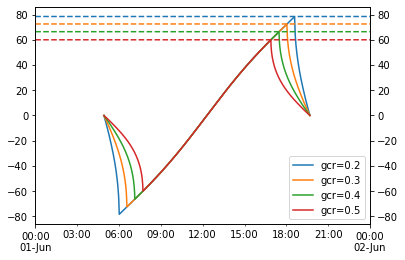

In [117]:
import pvlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
loc = pvlib.location.Location(40, -80)
times = pd.date_range('2019-06-01', '2019-06-02', freq='1min', tz='Etc/GMT+5')
solpos = loc.get_solarposition(times)

def get_sat(gcr, max_angle):
    tracker = pvlib.tracking.singleaxis(solpos.apparent_zenith,
                                        solpos.azimuth, 
                                        axis_tilt=0,
                                        axis_azimuth=180,
                                        max_angle=max_angle,
                                        backtrack=True,
                                        gcr=gcr)
    return tracker['tracker_theta']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for gcr in [0.2, 0.3, 0.4, 0.5]:
    max_angle = np.degrees(np.arccos(gcr))
    theta = get_sat(gcr, max_angle)
    theta.plot(ax=ax1, label=f'gcr={gcr}')
    pd.Series(max_angle, index=times).plot(ax=ax2, ls='--')

ax2.set_ylim(ax1.get_ylim())
ax1.legend(loc='lower right')

Let's do a slightly more rigorous validation using scipy to find the appropriate GCR for a given max angle numerically:

In [118]:
import scipy
def find_gcr(max_angle):
    def objective(gcr):
        theta = get_sat(gcr, max_angle)
        # optimize for two things:
        #  1) tiny difference between max observed angle and max allowed angle
        #  2) no time actually spent at max allowed angle
        # it's a little gross having a non-smooth error function like this, but it works ok here
        return abs(theta.abs().max() - max_angle) + ((theta.abs() - max_angle).abs() < 1e-3).sum()

    xopt = scipy.optimize.fminbound(objective, 0, 1, xtol=1e-2)

    return xopt

In [119]:
max_angles = np.arange(0, 90, 5)
gcrs = [find_gcr(ang) for ang in max_angles]

Text(0, 0.5, 'GCR')

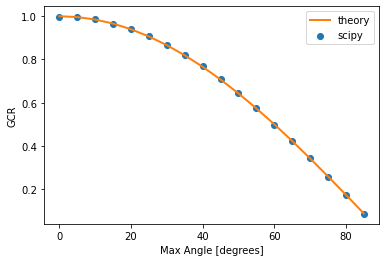

In [120]:
plt.scatter(max_angles, gcrs, label='scipy')
plt.plot(max_angles, np.cos(np.radians(max_angles)), label='theory', c='tab:orange', lw=2)
plt.legend()
plt.xlabel('Max Angle [degrees]')
plt.ylabel('GCR')